In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def encontrar_archivos(base_dir, nombre_archivo):
    archivos_encontrados = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file == nombre_archivo:
                ruta_completa = os.path.join(root, file)
                archivos_encontrados.append(ruta_completa)
    return archivos_encontrados

# Load the JSON file and print the top-level keys
def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def seleccionar_claves_excluyendo(diccionario, clave_a_excluir):
    # Crear un nuevo diccionario excluyendo la clave especificada
    nuevo_diccionario = {clave: valor for clave, valor in diccionario.items() if clave != clave_a_excluir}
    return nuevo_diccionario

# Load the JSON data
def read_json_file(file_path):
    json_data = load_json(file_path)
    best_model_content = json_data.get('best_model', None)
    metrics = json_data[best_model_content[0]][best_model_content[1]]['metrics']
    return metrics


def get_metrics_from_files(detailed_metrics_list, report_list):
    models_data = []

    for elem1, elem2 in zip(detailed_metrics_list, report_list):
        # for file in json_files_list:
        detailed_data = load_json(elem1)
        best_model_content = detailed_data.get('best_model', None)
        data = detailed_data[best_model_content[0]][best_model_content[1]]['metrics']
        new_data = {clave: valor[-1] for clave, valor in data.items()}
        new_data['model'] = elem1.split('/')[-2:][0]

        report = load_json(elem2)
        metadata = report['metadata']
        tags = report['tags']
        total_data = new_data | metadata
        total_data['tags'] =  tags

        models_data.append(total_data)

    return models_data

def get_normalization_type(row):
    if isinstance(row, list):
        for item in row:
            if isinstance(item, str) and item.startswith('N_'):
                return item
            
def get_pooling_type(row):
    if isinstance(row, list):
        for item in row:
            if isinstance(item, str) and item.startswith('P_'):
                return item
            
def get_dropout_type(row):
    if isinstance(row, list):
        for item in row:
            if isinstance(item, str) and item.startswith('D_'):
                return item

In [3]:
detailed_metrics_list = encontrar_archivos('/home/aacastro/Alejandro/DQ_ACA_2024/C/results/no_square', 'detailed_metrics.json')
report_list = encontrar_archivos('/home/aacastro/Alejandro/DQ_ACA_2024/C/results/no_square', 'custom_report.json')
models_data = get_metrics_from_files(detailed_metrics_list, report_list)

In [4]:
df = pd.DataFrame(models_data)
df.drop('model', axis=1, inplace=True)
df['normalization_type'] = df['tags'].apply(get_normalization_type)
df['pooling_type'] = df['tags'].apply(get_pooling_type)
df['dropout_type'] = df['tags'].apply(get_dropout_type)
# df['Num_conv'] = pd.Categorical(df['Num_conv'], categories=[3, 5, 7, 10], ordered=True)
df.head(5)

,f1_score,recall,precision,roc_auc,confusion_matrix,arch_name,arch,config,Num_conv,Num_denses,...,Num_droputs,KW,Filters,drop_ratio,folder,num_simulation,tags,normalization_type,pooling_type,dropout_type
0,0.590164,0.600000,0.580645,0.583333,"[[17, 13], [12, 18]]",architecture_10conv_3dense_18,"[C, C, C, C, C, C, C, C, C, C, N, P, flatten, ...",model19,10,3,...,3,50_cte,32_cte,0.5_cte,fold_3,sim_5,"[A#architecture_10conv_3dense_18, NC#10, NF#3,...",N_Parcial,P_Parcial,D_Parcial
1,0.509091,0.466667,0.560000,0.550000,"[[19, 11], [16, 14]]",architecture_5conv_11dense_25,"[C, C, C, C, C, flatten, F, F, F, D, F, F, F, ...",model12,5,11,...,3,50_cte,32_cte,0.5_cte,fold_3,sim_4,"[A#architecture_5conv_11dense_25, NC#5, NF#11,...",N_None,P_None,D_Full
2,0.610169,0.600000,0.620690,0.616667,"[[19, 11], [12, 18]]",architecture_7conv_7dense_11,"[C, N, P, C, N, P, C, N, P, C, N, P, C, N, P, ...",model16,7,7,...,0,50_cte,32_cte,0.5_cte,fold_3,sim_5,"[A#architecture_7conv_7dense_11, NC#7, NF#7, N...",N_Full,P_Full,D_None
3,0.000000,0.000000,0.000000,0.500000,"[[30, 0], [30, 0]]",architecture_5conv_3dense_25,"[C, C, C, C, C, flatten, F, F, F, D, 2048, 102...",model8,5,3,...,1,50_cte,32_cte,0.5_cte,fold_1,sim_5,"[A#architecture_5conv_3dense_25, NC#5, NF#3, N...",N_None,P_None,D_Full
4,0.606061,0.666667,0.555556,0.566667,"[[14, 16], [10, 20]]",architecture_10conv_3dense_30,"[C, C, C, C, C, C, C, C, C, C, N, P, flatten, ...",model20,10,3,...,1,50_cte,32_cte,0.5_cte,fold_3,sim_5,"[A#architecture_10conv_3dense_30, NC#10, NF#3,...",N_Parcial,P_Parcial,D_Full


In [13]:
df.shape

(24, 22)

In [16]:
# Encuentra el índice del máximo valor en la columna f1_score
indice_maximo = df['f1_score'].idxmax()

# Accede a la fila que contiene el máximo valor en f1_score
fila_maxima = df.loc[indice_maximo]
fila_maxima
# el report:
# https://app.evidently.cloud/projects/619dbd4a-bc10-4c9c-b0af-1224b4dadd29/reports/873c067b-2286-42b2-959d-f3e0e711373c

f1_score                                                       0.666667
recall                                                              1.0
precision                                                           0.5
roc_auc                                                             0.5
confusion_matrix                                     [[0, 30], [0, 30]]
arch_name                                  architecture_10conv_7dense_6
arch                  [C, C, C, C, C, C, C, C, C, C, N, P, flatten, ...
config                                                          model21
Num_conv                                                             10
Num_denses                                                            7
Num_pooling                                                           1
Num_normalization                                                     1
Num_droputs                                                           0
KW                                                              

In [19]:
# Ordena el DataFrame por la columna 'f1_score' en orden descendente
df_ordenado = df.sort_values(by='f1_score', ascending=False)

# Selecciona la segunda fila (índice 1) del DataFrame ordenado
fila_segundo_maximo = df_ordenado.iloc[2]
fila_segundo_maximo

f1_score                                                       0.610169
recall                                                              0.6
precision                                                       0.62069
roc_auc                                                        0.616667
confusion_matrix                                   [[19, 11], [12, 18]]
arch_name                                  architecture_7conv_7dense_11
arch                  [C, N, P, C, N, P, C, N, P, C, N, P, C, N, P, ...
config                                                          model16
Num_conv                                                              7
Num_denses                                                            7
Num_pooling                                                           7
Num_normalization                                                     7
Num_droputs                                                           0
KW                                                              

In [6]:
metricas = ['precision', 'recall', 'f1_score', 'roc_auc']

In [7]:
df.Num_conv.value_counts()

Num_conv
10    6
5     6
7     6
3     6
Name: count, dtype: int64

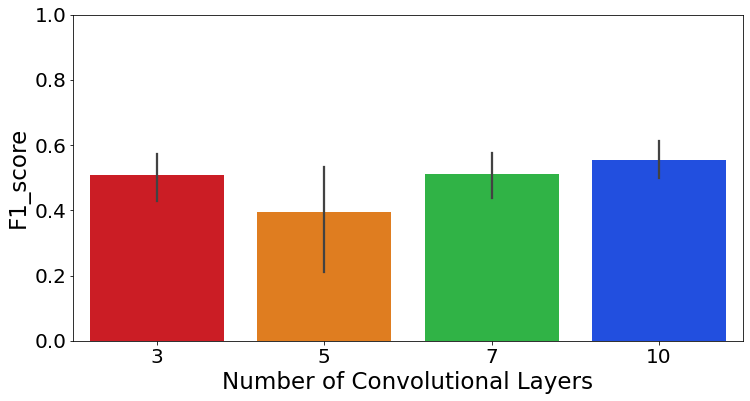

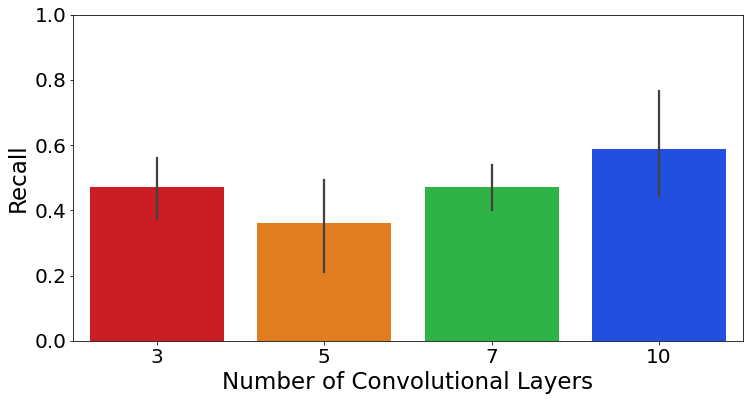

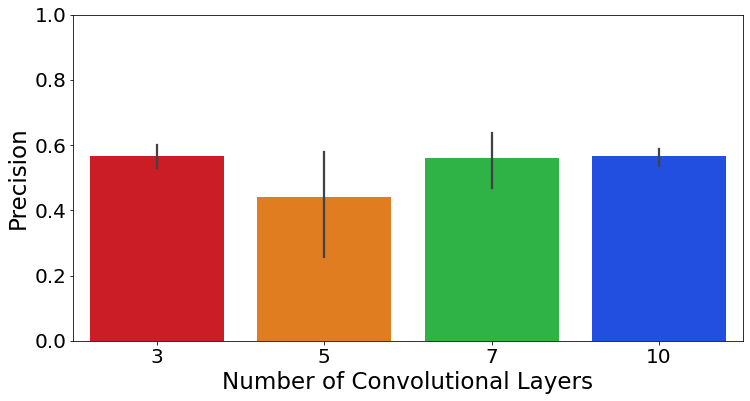

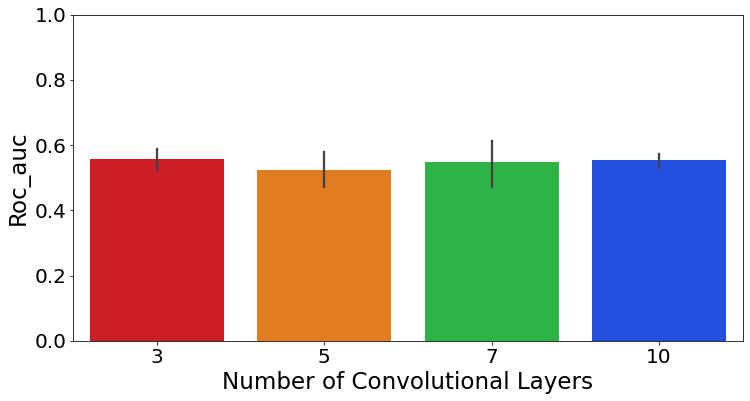

In [8]:
orden_num_conv = [3, 5, 7, 10]


# Asegurarse de que 'Num_conv' esté categorizado correctamente y en el orden deseado
# df['Num_conv'] = pd.Categorical(df['Num_conv'], categories=orden_num_conv, ordered=True)

# Lista de métricas para graficar
metricas = ['f1_score', 'recall', 'precision', 'roc_auc']

# Crear una gráfica de barras para cada métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    
    # Obtener una paleta de colores con tantos colores como barras haya
    num_barras = df['Num_conv'].nunique()  # Número de barras
    colores = sns.color_palette("bright", num_barras)  # Paleta de colores con tantos colores como barras
    
    # Crear el gráfico de barras asignando `hue` a `Num_conv` y desactivando la leyenda
    sns.barplot(x='Num_conv', y=metrica, hue='Num_conv', data=df, palette=colores, order=orden_num_conv)
    
    # Configurar el título y etiquetas del gráfico
    plt.xlabel('Number of Convolutional Layers', fontsize=23)
    plt.ylabel(metrica.capitalize(), fontsize=23)
    
    # Mostrar el gráfico
    plt.ylim(0, 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

In [14]:
df.Num_denses.value_counts()

Num_denses
3     8
11    8
7     8
Name: count, dtype: int64

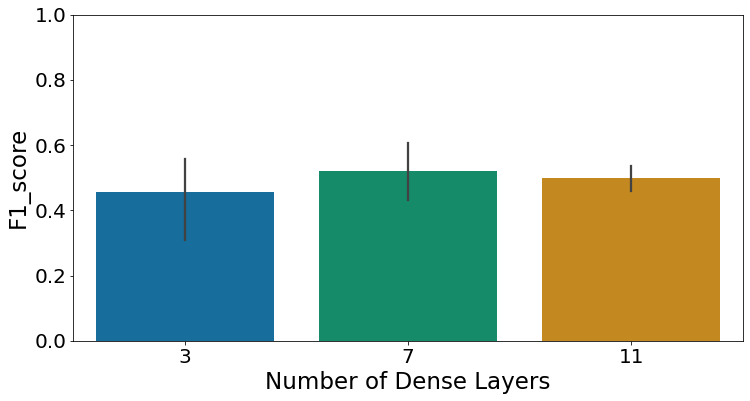

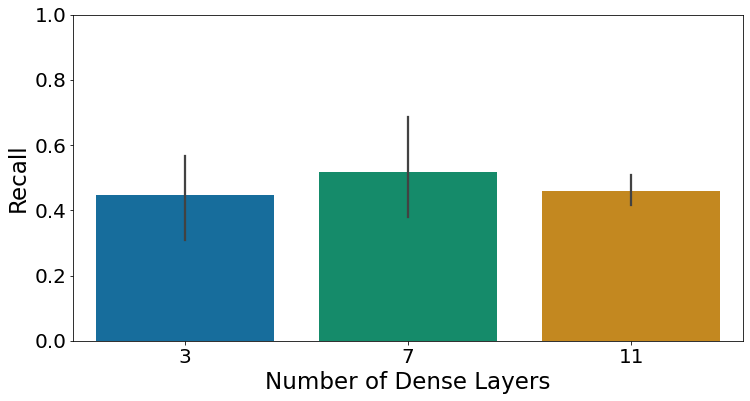

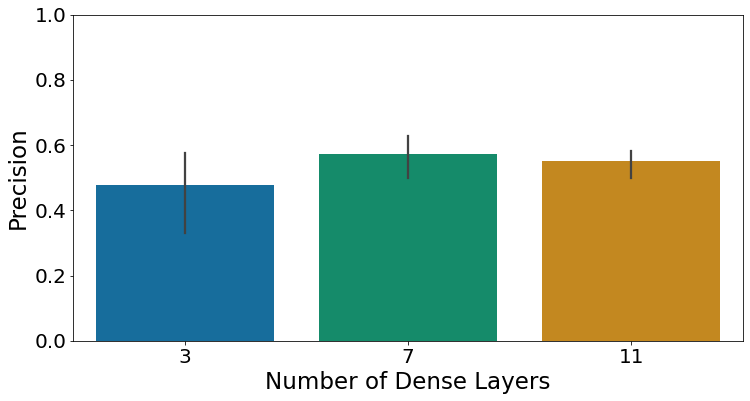

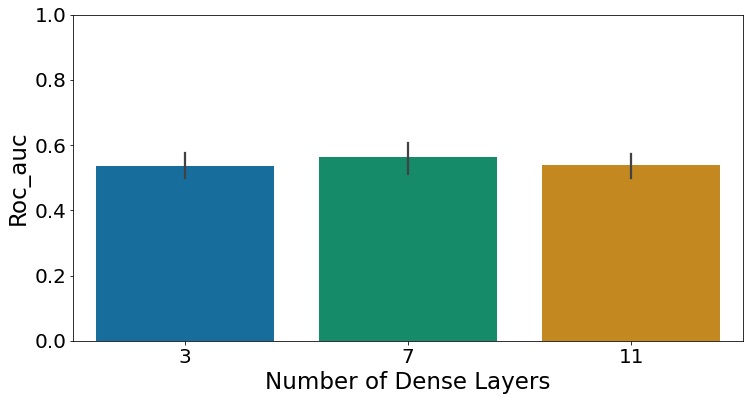

In [9]:
# Crear una gráfica de barras para cada métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    orden_dense = [3, 7, 11]
    
    # Obtener una paleta de colores con tantos colores como barras haya
    num_barras = df['Num_denses'].nunique()  # Número de barras
    colores = sns.color_palette("colorblind", num_barras)  # Paleta de colores con tantos colores como barras
    
    # Crear el gráfico de barras asignando `hue` a `Num_conv` y desactivando la leyenda
    sns.barplot(x='Num_denses', y=metrica, hue='Num_denses', data=df, palette=colores, order=orden_dense)
    
    # Configurar el título y etiquetas del gráfico
    # plt.title(f'{metrica.capitalize()} based on the Number of Dense Layers')
    plt.xlabel('Number of Dense Layers', fontsize=23)
    plt.ylabel(metrica.capitalize(), fontsize=23)
    
    # Mostrar el gráfico
    plt.ylim(0, 1)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

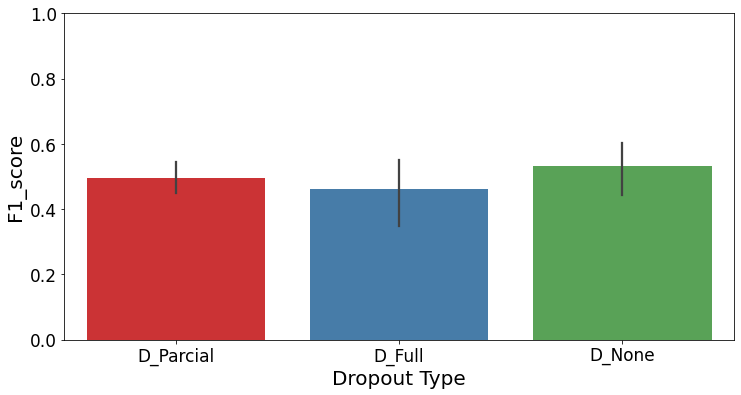

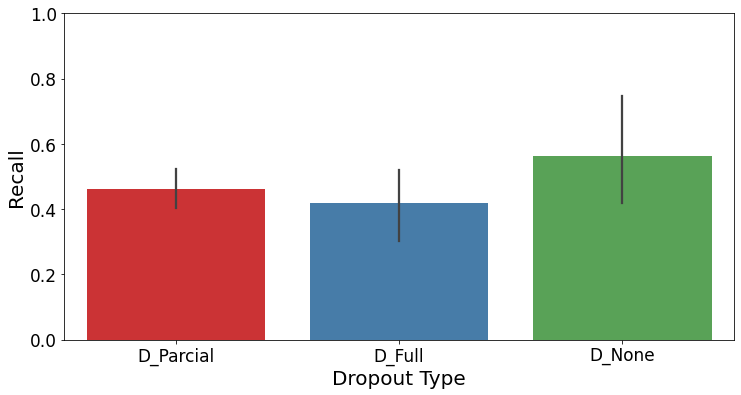

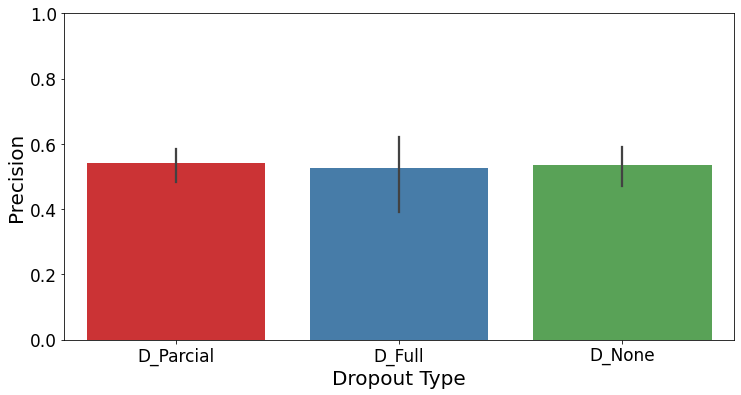

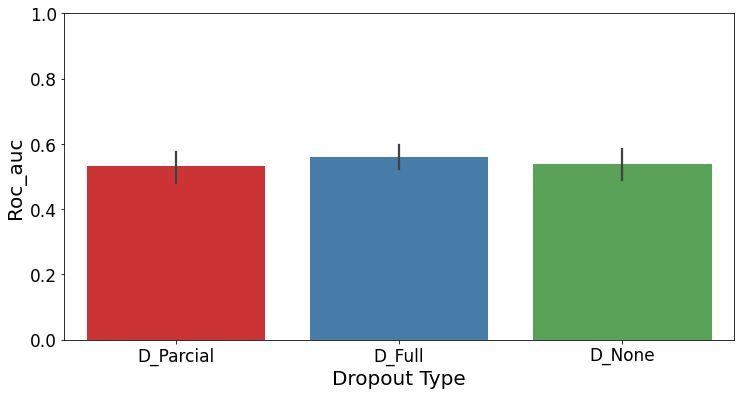

In [10]:
# Crear una gráfica de barras para cada métrica
orden_dropout = ['N_Parcial', 'N_None', 'N_Full']
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    
    # Obtener una paleta de colores con tantos colores como barras haya
    num_barras = df['dropout_type'].nunique()  # Número de barras
    colores = sns.color_palette("Set1", num_barras)  # Paleta de colores con tantos colores como barras
    
    # Crear el gráfico de barras asignando `hue` a `Num_conv` y desactivando la leyenda
    sns.barplot(x='dropout_type', y=metrica, hue='dropout_type', data=df, palette=colores, dodge=False, legend=False, order=orden_dropout)
    
    # Configurar el título y etiquetas del gráfico
    # plt.title(f'{metrica.capitalize()} based on the Dropout Type')
    plt.xlabel('Dropout Type', fontsize=20)
    plt.ylabel(metrica.capitalize(), fontsize=20)
    
    # Mostrar el gráfico
    plt.ylim(0, 1)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.show()

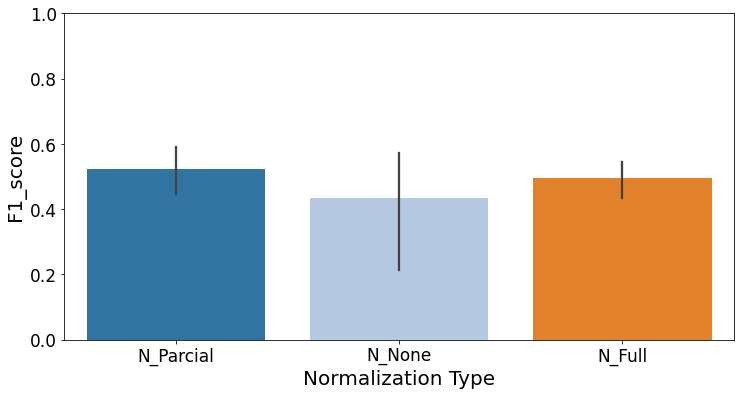

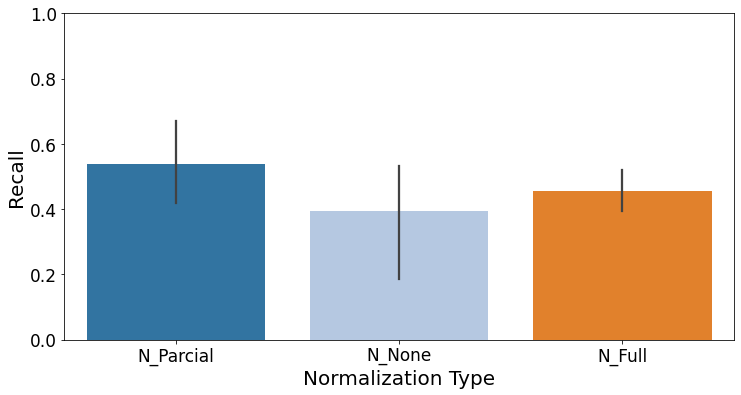

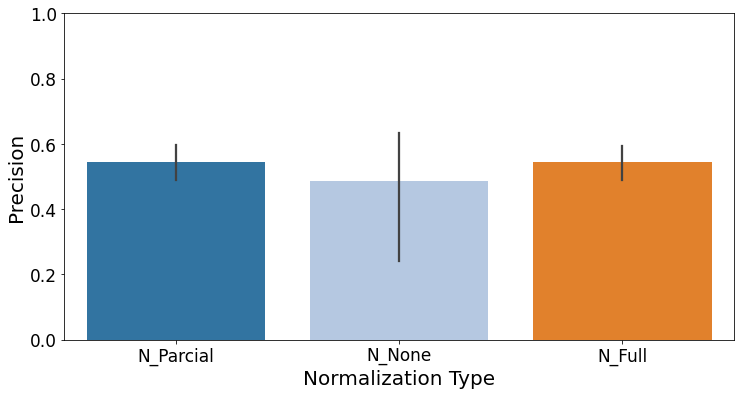

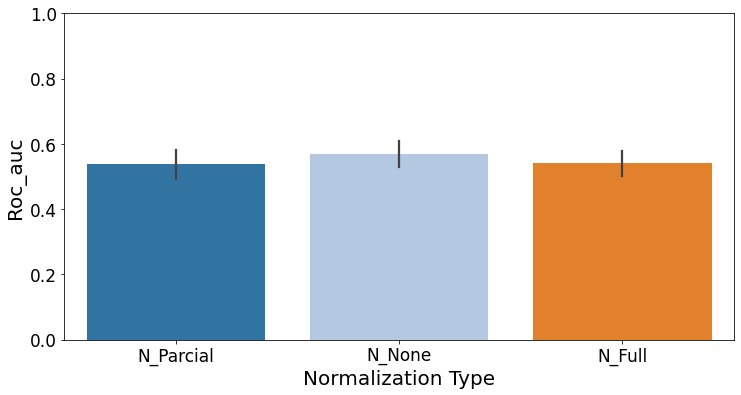

In [11]:
# Crear una gráfica de barras para cada métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    
    # Obtener una paleta de colores con tantos colores como barras haya
    num_barras = df['normalization_type'].nunique()  # Número de barras
    colores = sns.color_palette("tab20", num_barras)  # Paleta de colores con tantos colores como barras
    
    # Crear el gráfico de barras asignando `hue` a `Num_conv` y desactivando la leyenda
    sns.barplot(x='normalization_type', y=metrica, hue='normalization_type', data=df, palette=colores, dodge=False, legend=False)
    
    # Configurar el título y etiquetas del gráfico
    # plt.title(f'{metrica.capitalize()} based on the Normalization Type')
    plt.xlabel('Normalization Type', fontsize=20)
    plt.ylabel(metrica.capitalize(), fontsize=20)
    
    # Mostrar el gráfico
    plt.ylim(0, 1)
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    plt.show()

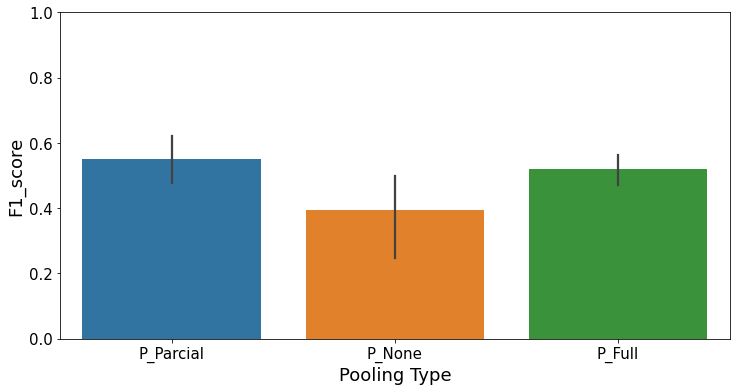

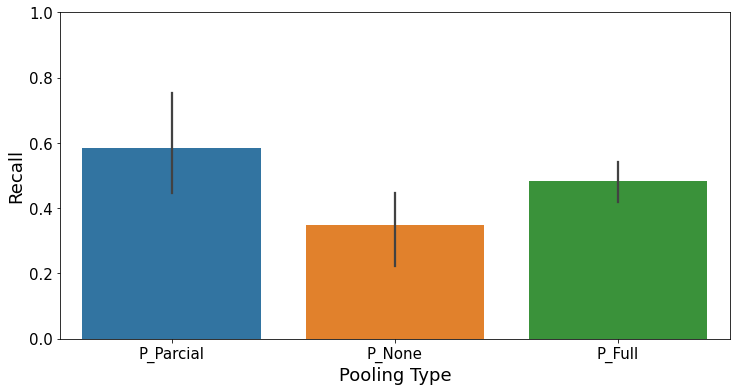

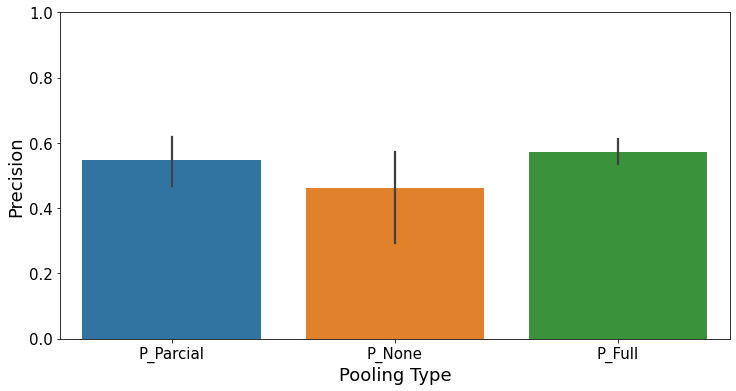

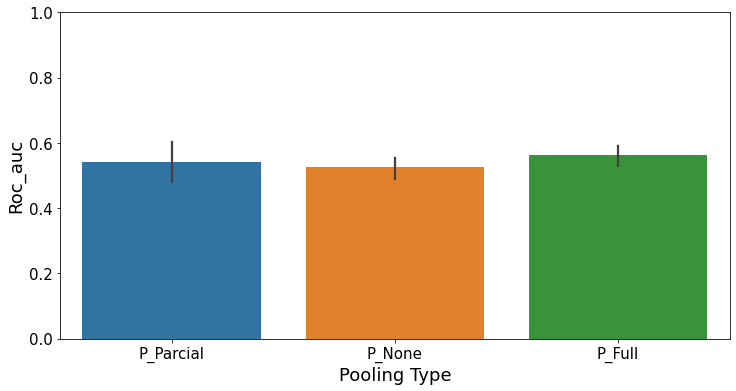

In [12]:
# Crear una gráfica de barras para cada métrica
for metrica in metricas:
    plt.figure(figsize=(12, 6))
    
    # Obtener una paleta de colores con tantos colores como barras haya
    num_barras = df['pooling_type'].nunique()  # Número de barras
    colores = sns.color_palette("tab10", num_barras)  # Paleta de colores con tantos colores como barras
    
    # Crear el gráfico de barras asignando `hue` a `Num_conv` y desactivando la leyenda
    sns.barplot(x='pooling_type', y=metrica, hue='pooling_type', data=df, palette=colores, dodge=False, legend=False)
    
    # Configurar el título y etiquetas del gráfico
    # plt.title(f'{metrica.capitalize()} based on the Number of Pooling Type')
    plt.xlabel('Pooling Type', fontsize=18)
    plt.ylabel(metrica.capitalize(), fontsize=18)
    
    # Mostrar el gráfico
    plt.ylim(0, 1)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()